##### Config

In [1]:
%matplotlib inline

In [2]:
%config InlineBackend.figure_format = "retina"

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# Disable annoying font warnings
matplotlib.font_manager._log.setLevel(50)

# Disable theano deprecation warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning, module='theano')

# Style
plt.style.use('default')
plt.rcParams['savefig.dpi'] = 100
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = (12, 4)
plt.rcParams['font.size'] = 14
plt.rcParams['text.usetex'] = False
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Liberation Sans']
plt.rcParams['font.cursive'] = ['Liberation Sans']
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['mathtext.fallback_to_cm'] = True

In [4]:
del matplotlib; del plt; del warnings

##### Main

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from scipy.special import factorial
import george
from george.kernels import CosineKernel

In [6]:
def g(n):
    if n % 2 == 0:
        return factorial(n) / (2 ** (n // 2) * factorial(n // 2))
    else:
        return 0


def norm_cov(mu, Sig, N=20):
    K = Sig.shape[0]
    J = np.ones((K, K))
    barSig = np.mean(Sig)

    # Powers of S / barSig
    G = (Sig @ J) / K ** 2 / barSig
    Gpow = [np.eye(K)]
    for n in range((N + 2) // 2):
        Gpow.append(Gpow[-1] @ G)

    norm_cov = np.zeros_like(Sig)
    for n in range(0, N + 1, 2):
        fac = (-1) ** n * (n + 1) * g(n) * barSig ** (n // 2) / (mu ** n)
        norm_cov += fac * (
            Sig
            + n * (Gpow[n // 2]) @ Sig
            + (n + 1) * barSig * J
            - (n + 1) * barSig * K * (Gpow[(n + 2) // 2] + Gpow[(n + 2) // 2].T)
        )

    return norm_cov / mu ** 2

In [7]:
# GP Mean
mu = 0.75

# GP Amplitude
std = 0.1

# Asymmetry term
offset = 0.5

# Dimension
K = 1000

# Number of samples in numerical estimate
M = 100000

# Expansion order in our series solution
N = 20

In [35]:
# Get the covariance matrix
t = np.linspace(0, 1, K)
period = 2.0
period = 0.75
kernel = std ** 2 * (offset + CosineKernel(np.log(period)))
gp = george.GP(kernel)
gp.compute(t)
Sigma = gp.get_matrix(t)

In [36]:
# Draw `M` samples, normalize them,
# and compute the covariance
x = mu + gp.sample(size=M)
mean = np.mean(x, axis=1)[:, None]
xnorm = x / mean
Sigma_norm_num = np.cov(xnorm.T)

In [37]:
# Compute the normalized covariance using the series expansion
Sigma_norm_series = norm_cov(mu, Sigma, N=N)

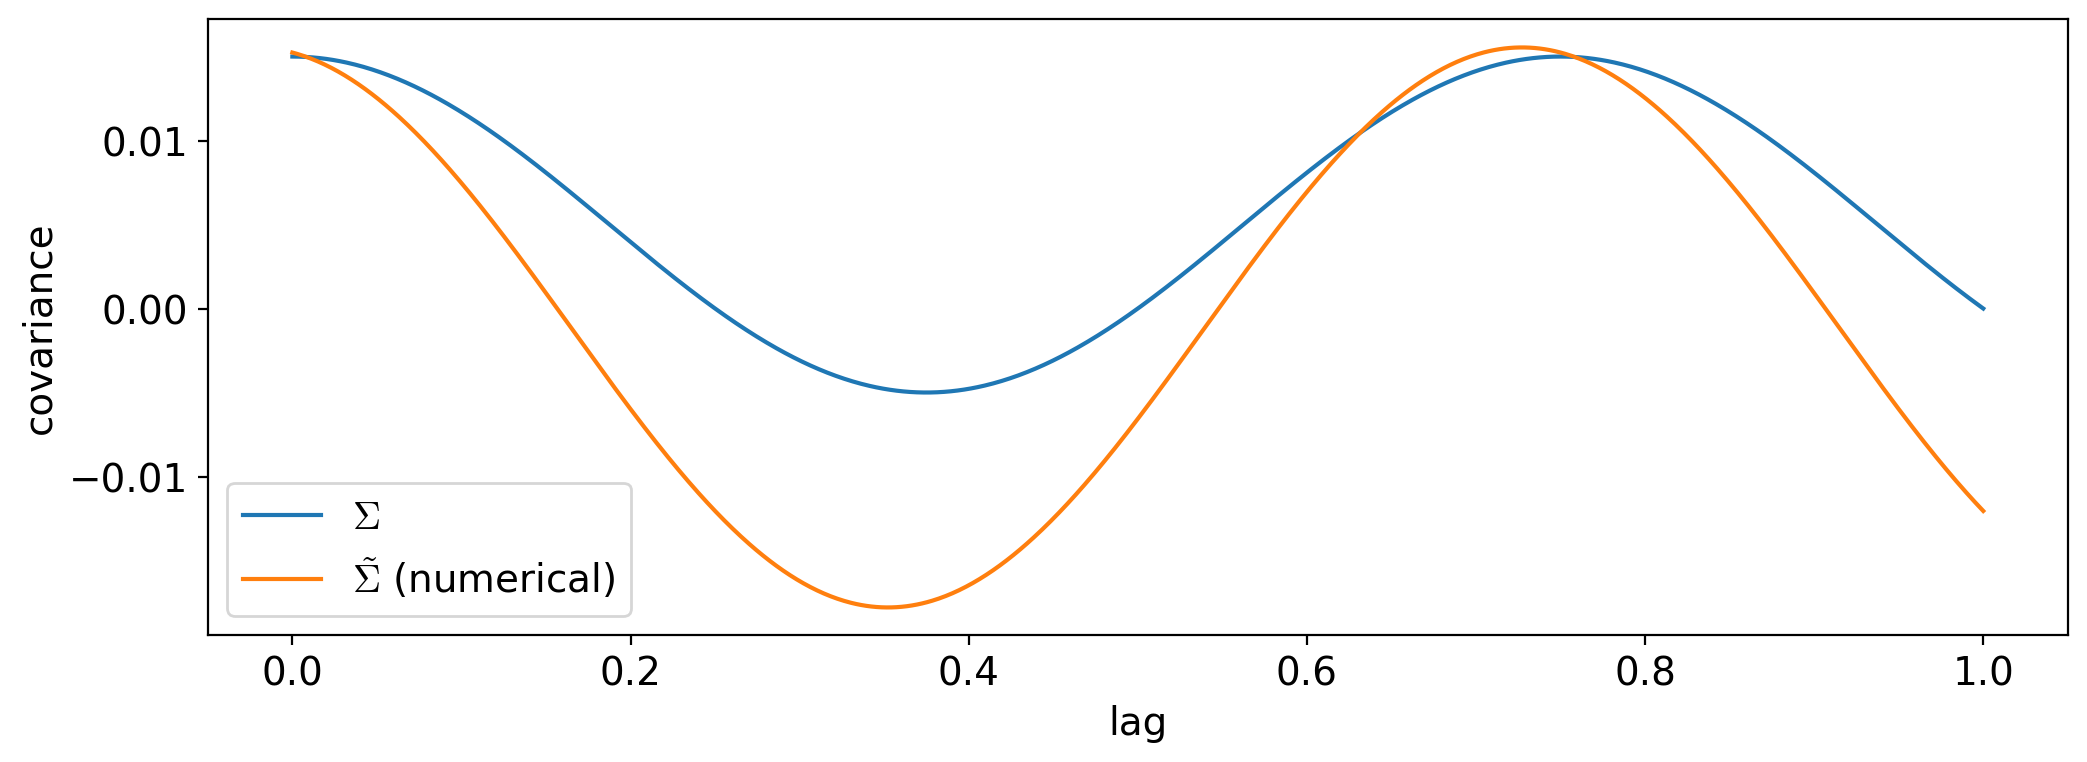

In [38]:
# Plot the original covariance and the numerical normalized covariance
plt.plot(t, Sigma[0], label=r"$\Sigma$")
plt.plot(t, Sigma_norm_num[0], label=r"$\tilde{\Sigma}$ (numerical)")
plt.legend()
plt.xlabel("lag")
plt.ylabel("covariance");

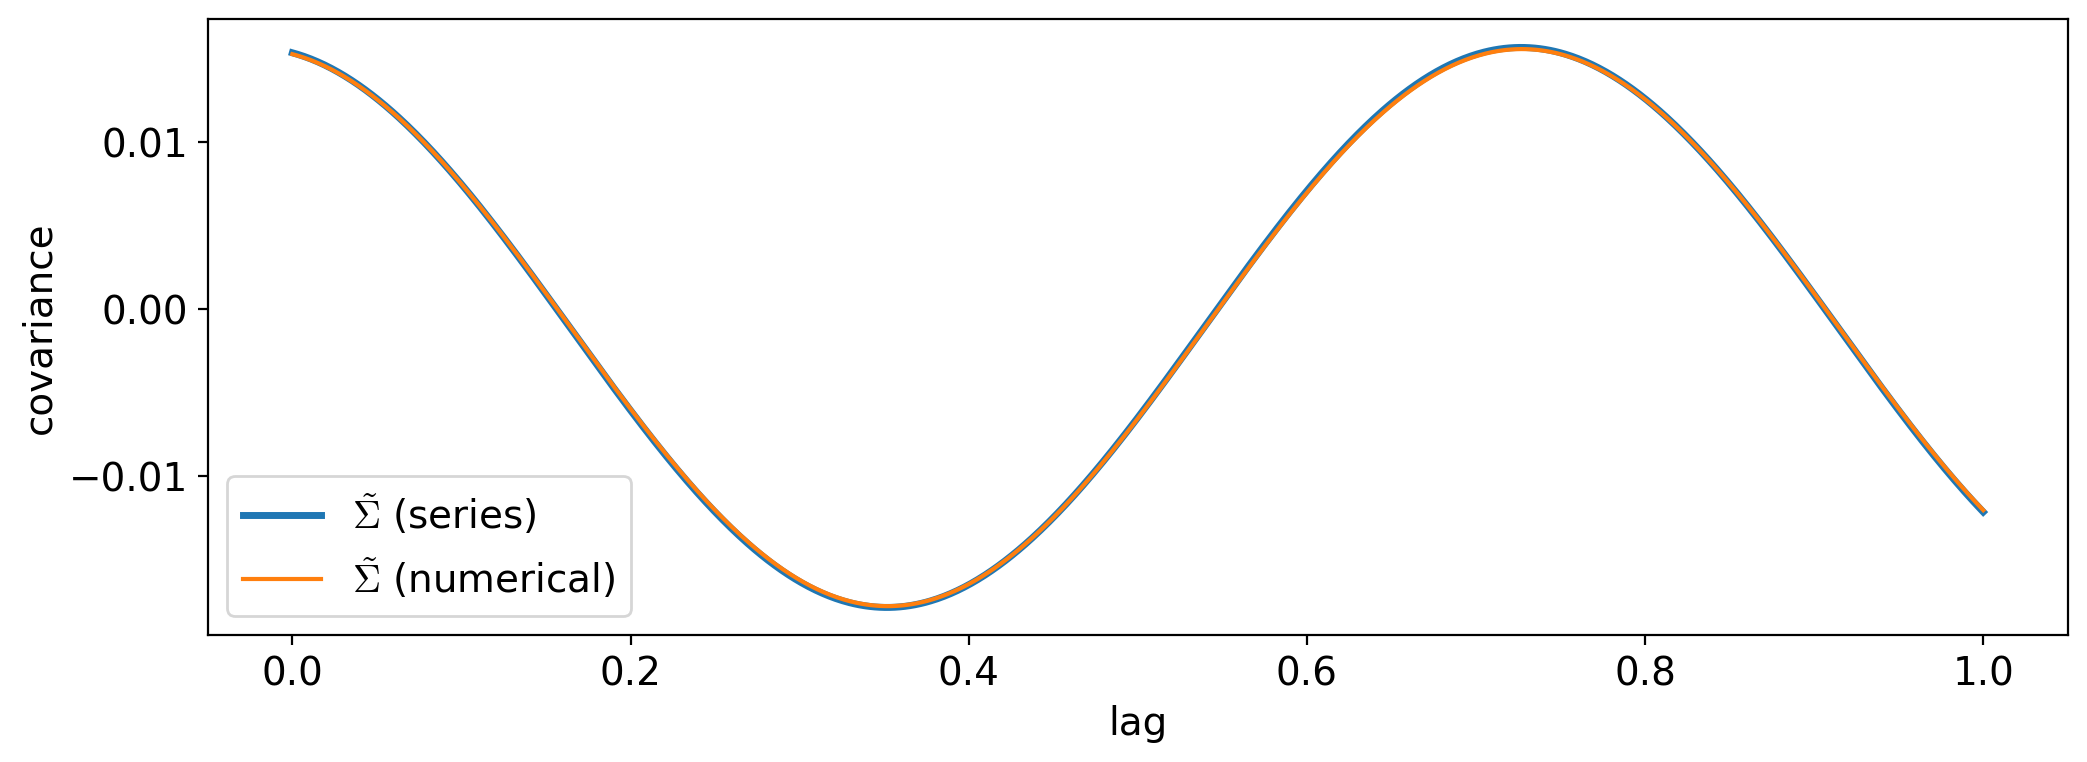

In [39]:
# Plot the series solution and the numerical solution
plt.plot(t, Sigma_norm_series[0], label=r"$\tilde{\Sigma}$ (series)", lw=2.5)
plt.plot(t, Sigma_norm_num[0], label=r"$\tilde{\Sigma}$ (numerical)")
plt.legend()
plt.xlabel("lag")
plt.ylabel("covariance");

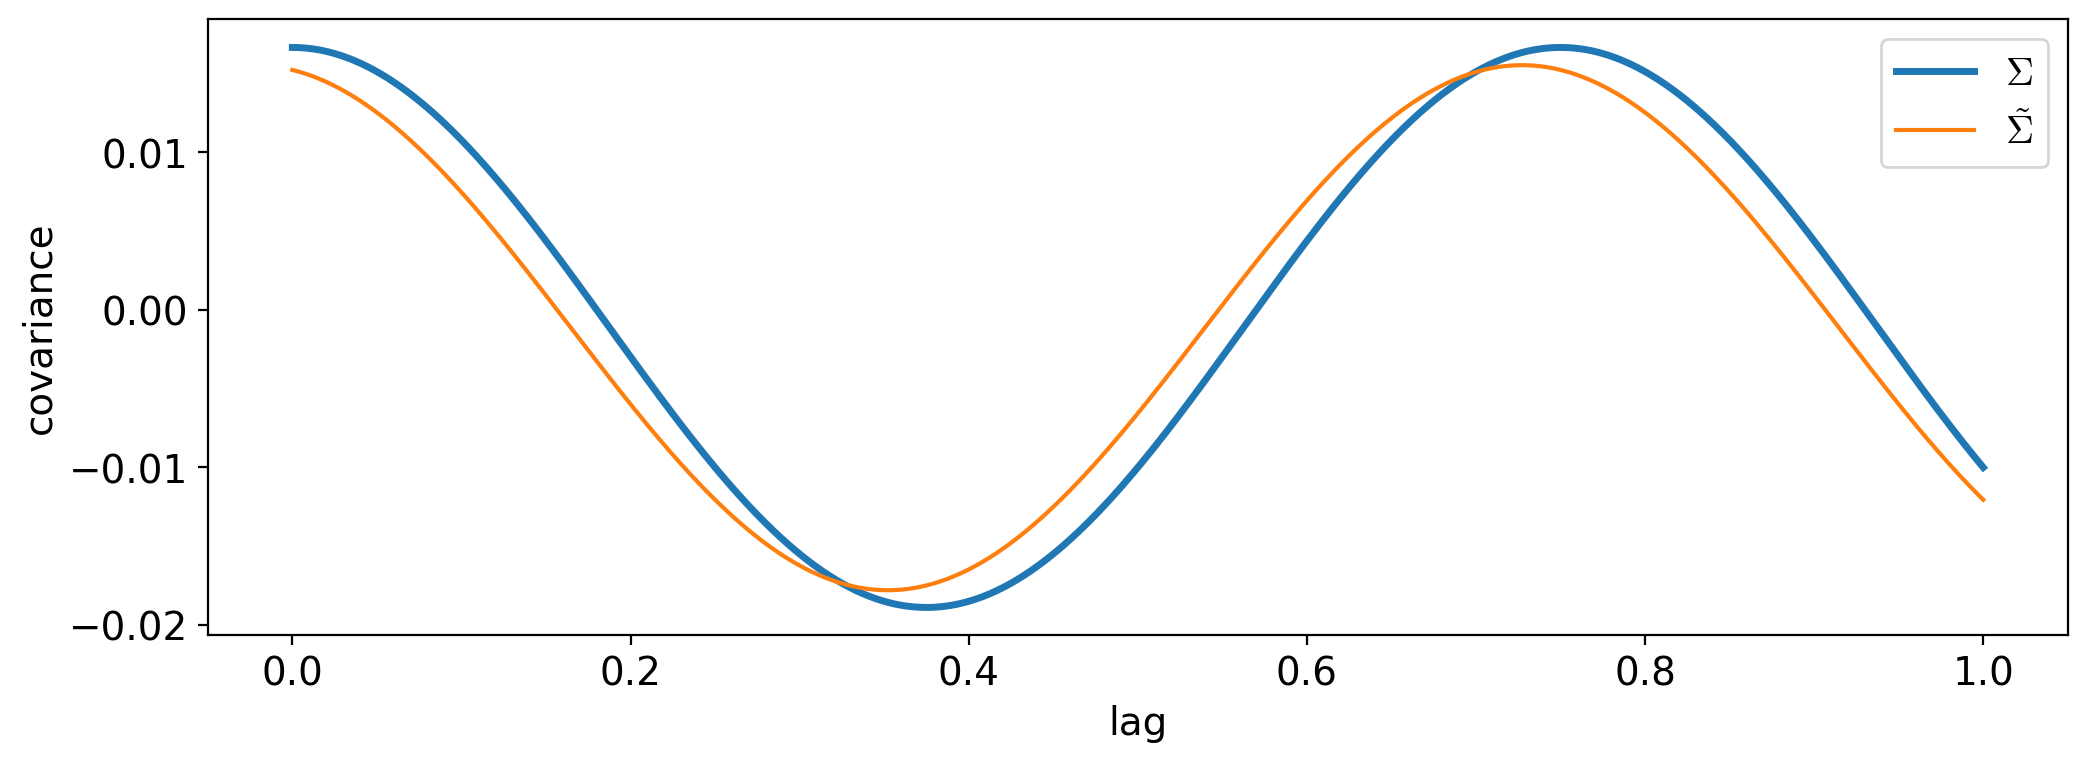

In [41]:
# Show that the *period* changed!!!
plt.plot(t, Sigma[0] / mu ** 2 - 0.01, label=r"$\Sigma$", lw=2.5)
plt.plot(t, Sigma_norm_num[0], label=r"$\tilde{\Sigma}$")
plt.legend()
plt.xlabel("lag")
plt.ylabel("covariance");

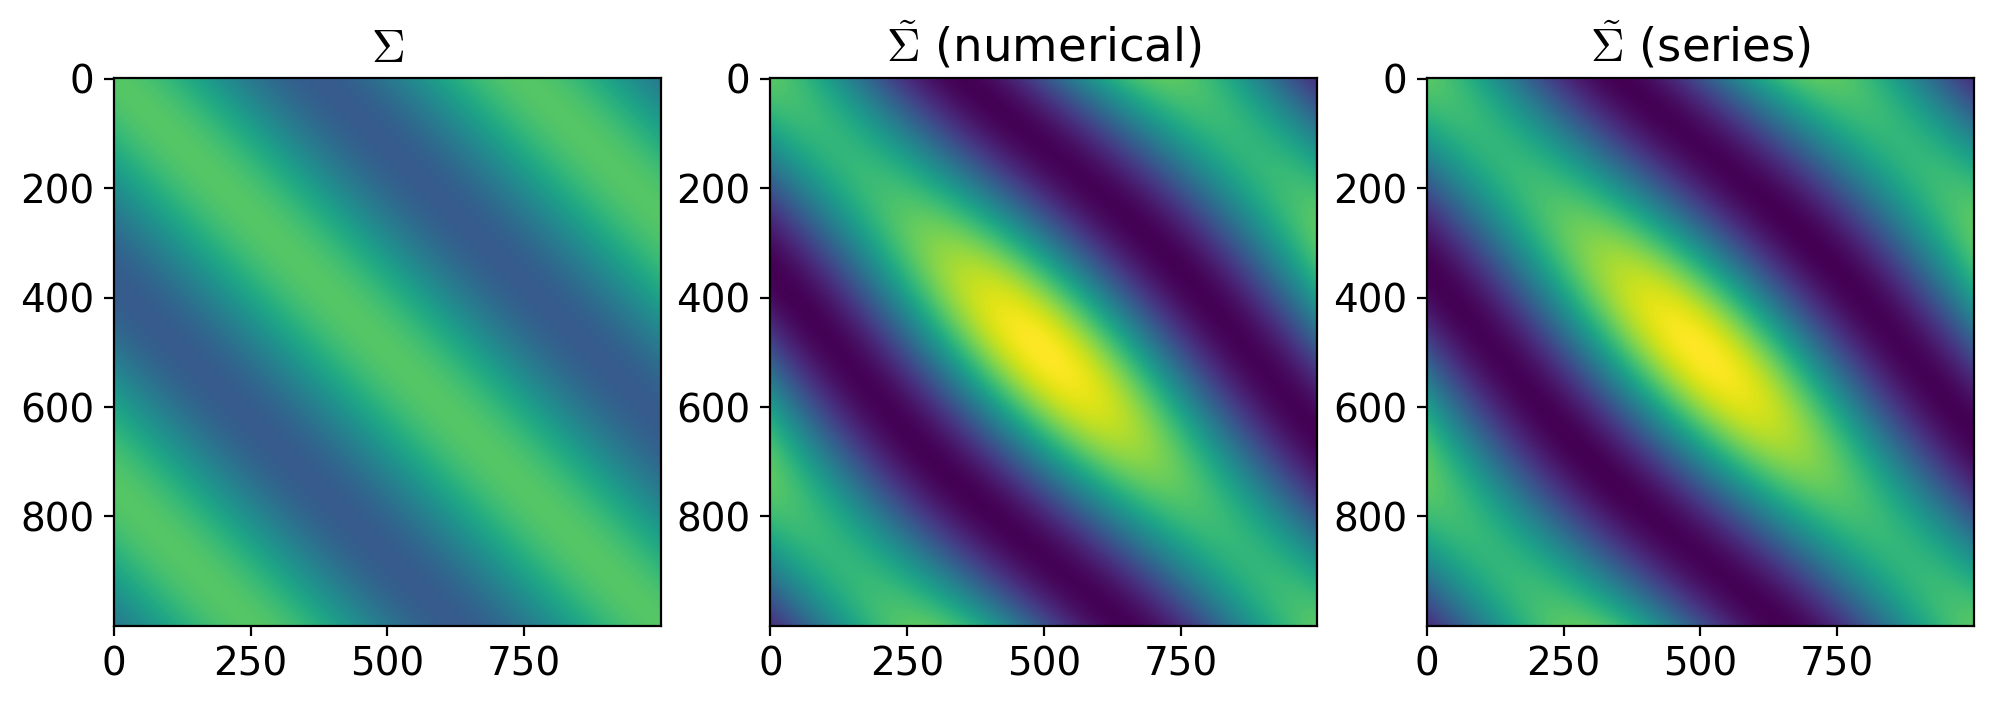

In [42]:
fig, ax = plt.subplots(1, 3)
vmin = Sigma_norm_series.min()
vmax = Sigma_norm_series.max()
ax[0].imshow(Sigma, vmin=vmin, vmax=vmax)
ax[1].imshow(Sigma_norm_num, vmin=vmin, vmax=vmax)
ax[2].imshow(Sigma_norm_series, vmin=vmin, vmax=vmax);
ax[0].set_title(r"$\Sigma$")
ax[1].set_title(r"$\tilde{\Sigma}$ (numerical)")
ax[2].set_title(r"$\tilde{\Sigma}$ (series)");

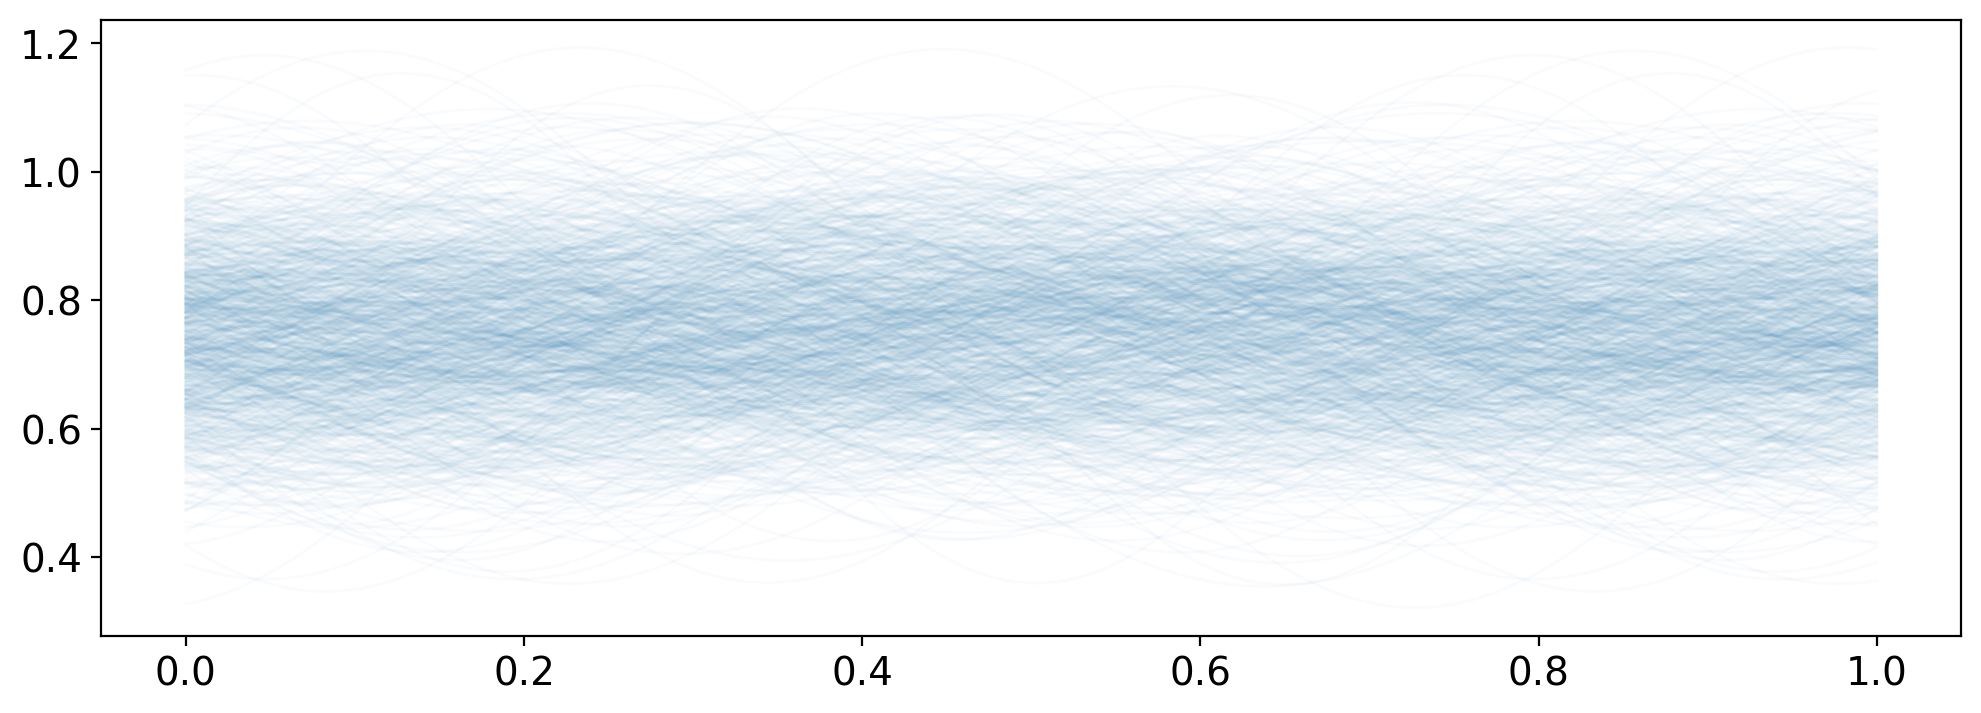

In [43]:
for k in range(1000):
    plt.plot(t, x[k], "C0-", lw=1, alpha=0.025)

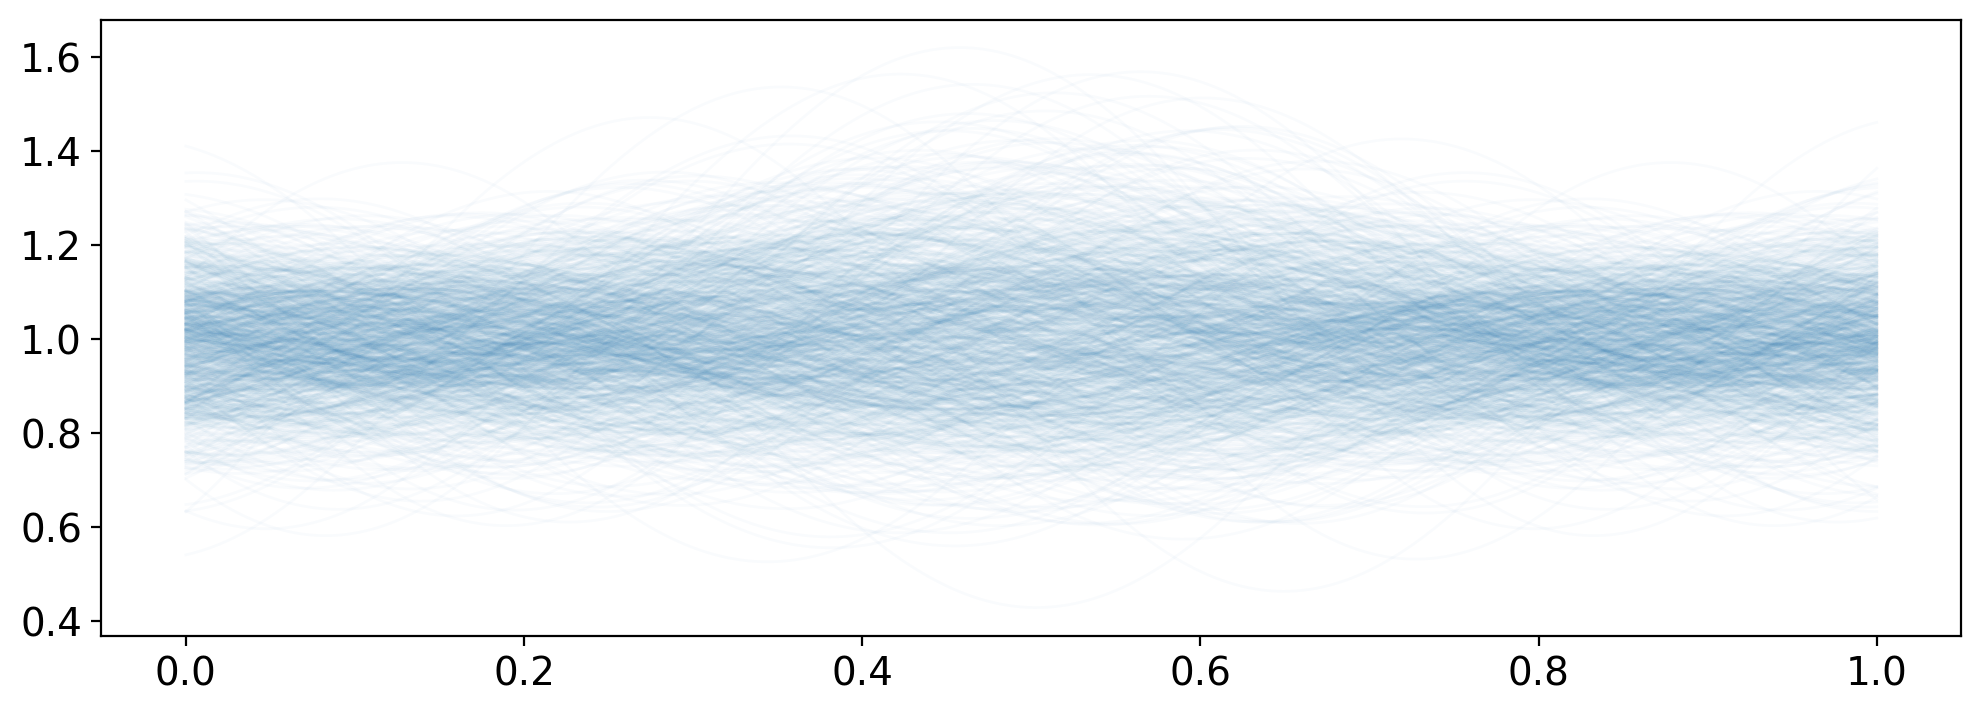

In [44]:
for k in range(1000):
    plt.plot(t, xnorm[k], "C0-", lw=1, alpha=0.025)

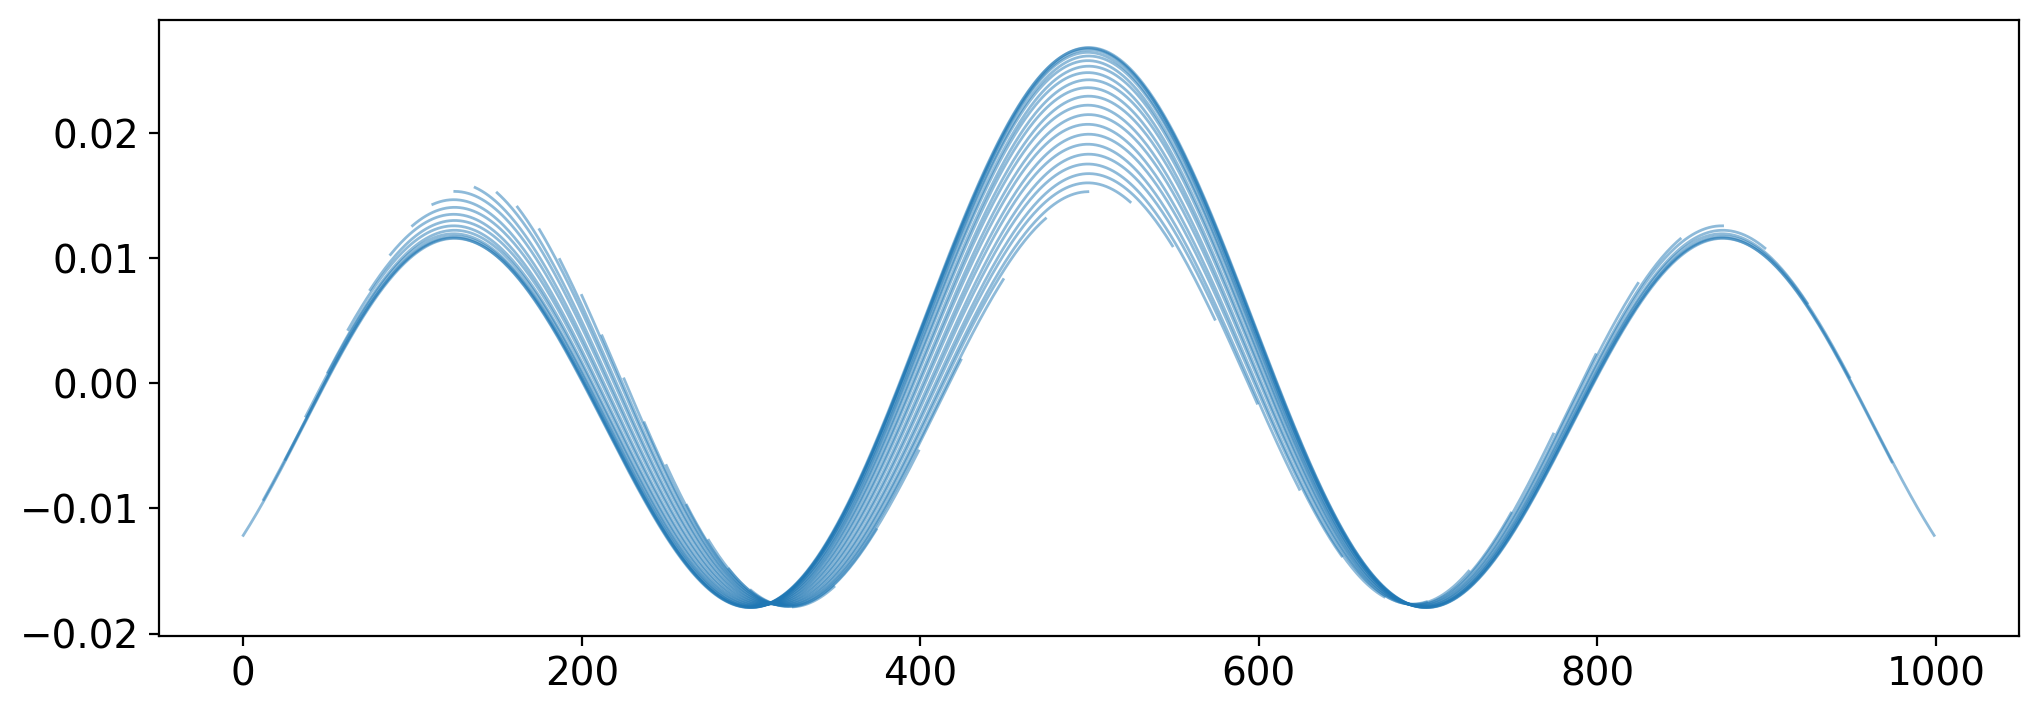

In [45]:
S = np.fliplr(Sigma_norm_series)

for k in range(0, 1000, 25):
    x = np.roll(np.diag(S, k), k // 2)
    x[: k // 2] = np.nan
    tk = np.arange(len(x))
    plt.plot(tk, x, color="C0", lw=1, alpha=0.5)